**Continued from Part 2 Author Lifespan**

As we saw in Part 1, cross-posters appeared to be unusually active during the period between mid 2012 and mid 2013. One way to figure out what happened is to compute the divergence of linguisitc pattern (e.g. word frequencies) of posts from the two subreddits, and see if there is a valley for the divergence curve (or peak for the similarity curve) where we saw the peak in the red curves in Part 1.

Here we consider the posts of cross-posters (superscript $x$) from **MensRights** ($C_{M, t}^{x}$) and from **Feminism** ($C_{F, t}^{x}$) and compute the similarity/divergence between $C_{M, t}^{x}$ and $C_{F, t}^{x}$ as a function of time $t$. As a comparison, we also consider the posts from MensRights-only (superscript $o$) authors ($C_{M, t}^{o}$) and Feminism-only authors ($C_{F, t}^{o}$), and compute similarity/divergence between $C_{M, t}^{o}$ and $C_{F, t}^{o}$.

Here is an example. We first need to build a dataframe with the following columns:
* author
* body
* created_utc
* subreddits (number of subreddits (1 or 2) the author has posted in)
* subreddit

In [1]:
import pickle
import datetime
import seaborn as sns

import pandas as pd
from pandas import DataFrame, Series
from utils import *

men = pickle.load(open("../../../MensRights_RC_2014-06.pickle"))
fem = pickle.load(open("../../../Feminism_RC_2014-06.pickle"))

df = pd.concat([men, fem], axis=0)
day_start = datetime.datetime(year=2014, month=6, day=1)
day_end = datetime.datetime(year=2014, month=6, day=11)

df["created_utc"] = df["created_utc"].astype(int).map(datetime.datetime.fromtimestamp)
df = df[(df["created_utc"] >= day_start) & (df["created_utc"] <= day_end)]

df = df.sort_values(by="created_utc")
author_info = df.groupby("author").apply(lambda x: len(x["subreddit"].unique()))
author_info.name = "subreddits"

author_info = author_info.reset_index(drop=False)

df = df.merge(author_info, left_on="author", right_on="author")
df = df[["author", "body", "created_utc", "subreddits", "subreddit"]]
df[:2]

,author,body,created_utc,subreddits,subreddit
0,termd,I'm mostly confused about her complaints becau...,2014-06-01 00:00:18,1,MensRights
1,termd,No.\n\nI'm also not a drunken idiot and don't ...,2014-06-01 00:04:37,1,MensRights


First we take a sample of cross-posters IDs:

In [2]:
df[df["subreddits"] == 2]["author"].unique()[:5]

array([u'[deleted]', u'autowikibot', u'RedRobin77', u'phatphace',
       u'Astiolo'], dtype=object)

A sample of MensRights-only author IDs:

In [3]:
df[(df["subreddits"] == 1) & (df["subreddit"] == "MensRights")]["author"].unique()[:5]

array([u'termd', u'Piroko', u'not_just_amwac', u'Dann01', u'Meistermalkav'], dtype=object)

A sample of Feminism-only author IDs:

In [4]:
df[(df["subreddits"] == 1) & (df["subreddit"] == "Feminism")]["author"].unique()[:5]

array([u'arwenface', u'FoKFill', u'a_grotesqueanimal', u'sinn7',
       u'IndieLady'], dtype=object)

Now let's pull some **MensRights** and **Feminism** posts from cross-poster *Astiolo*

In [5]:
df[df["author"] == "Astiolo"]

,author,body,created_utc,subreddits,subreddit
6078,Astiolo,I don't really see her view as particularly co...,2014-06-01 05:16:30,2,MensRights
6079,Astiolo,"I think the biologist was spot on with this, s...",2014-06-06 15:52:29,2,Feminism


**MensRights** posts from MensRights-only author *termd*

In [6]:
df[df["author"] == "termd"]

,author,body,created_utc,subreddits,subreddit
0,termd,I'm mostly confused about her complaints becau...,2014-06-01 00:00:18,1,MensRights
1,termd,No.\n\nI'm also not a drunken idiot and don't ...,2014-06-01 00:04:37,1,MensRights


**Feminism** posts from Feminism-only author *arwenface*

In [7]:
df[df["author"] == "arwenface"]

,author,body,created_utc,subreddits,subreddit
4635,arwenface,"The pink dump truck is a nice touch, though.",2014-06-01 01:06:18,1,Feminism


Using the notation defined previously, 

$C_{M, t}^{x} =$ ["I don't really see her view as particularly co..."]

$C_{F, t}^{X} =$ ["I think the biologist was spot on with this, s..."]

$C_{M, t}^{o} =$ ["I'm mostly confused about her complaints becau...", "No.\n\nI'm also not a drunken idiot and don't ..."]

$C_{F, t}^{o} =$ ["The pink dump truck is a nice touch, though."]

Note that time $t$ is discretized into a 10-day window, so each of the above sets is restricted to posts within a +/- 5 day window

Having described an intuitive example, let's prepare the data from plotting the similarity/divergence curves.

First we need a dataframe indexed on individual dates that contains the list of authors from groups within a 10-day window:
* cross-posters
* MensRights-only authors
* Feminism-only authors

In [8]:
import pickle
import datetime
import sys

import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import matplotlib.pyplot as plt

mensrights = pickle.load(open("MensRights.pickle"))
gb_key = mensrights["created_utc"].map(lambda d: 
                                       datetime.datetime(d.year, d.month, d.day))
men_author_groupby_day = mensrights.groupby(gb_key).apply(lambda x: 
                                                          x["author"].unique())
del mensrights

feminism = pickle.load(open("Feminism.pickle"))
gb_key = feminism["created_utc"].map(lambda d: 
                                     datetime.datetime(d.year, d.month, d.day))
fem_author_groupby_day = feminism.groupby(gb_key).apply(lambda x: 
                                                        x["author"].unique())
del feminism

In [9]:
men_author_groupby_day[:2]

created_utc
2008-03-21      [kanuk876]
2008-03-24    [WorcesterM]
dtype: object

In [10]:
fem_author_groupby_day[:2]

created_utc
2009-02-06    [stellar1]
2009-04-13      [Smight]
dtype: object

In [11]:
author_groupby_day = pd.concat([men_author_groupby_day, fem_author_groupby_day],
                               axis=1, keys=["men_author", "fem_author"])
author_groupby_day = author_groupby_day.sort_index(axis=0)

author_groupby_day[-2:]

,men_author,fem_author
created_utc,,
2016-07-30,"[Real_nimr0d, elebrin, sillymod, JohnKimble111...","[Amvega, demmian, conuly, Hobbes_the_tiger, Ad..."
2016-07-31,"[Lethn, hhamama66, civilsaint, Foregen_Is_Life...","[polot38, HeavenlySun, weinbrandbabsi, raloicl..."


In [12]:
"""
Define a helper function that computes the list of authors to be applied on each
row of the dataframeauthor_groupby_day
"""  

radius = 5

def group_author(row):
    # row: Series
    # row.name: index value of the row (i.e. datetime)
    date = row.name
    days = [date + datetime.timedelta(days=d) for d in range(-radius, radius)]

    men_author = []
    fem_author = []
    for d in days:
        if d in author_groupby_day.index:
            if author_groupby_day.ix[d, "men_author"] is not np.nan:
                men_author.extend(list(author_groupby_day.ix[d, "men_author"]))
            if author_groupby_day.ix[d, "fem_author"] is not np.nan:
                fem_author.extend(list(author_groupby_day.ix[d, "fem_author"]))

    men_author = set(men_author)
    fem_author = set(fem_author)
    # crssposter would just be the intersection
    crossposter = men_author & fem_author
    men_only = men_author - crossposter
    fem_only = fem_author - crossposter

    return Series([crossposter, men_only, fem_only], index=["cp", "men_only", "fem_only"])

In [13]:
author_group = author_groupby_day.apply(lambda row: group_author(row), axis=1)
author_group.to_pickle("author_group.pickle")

Having built the dataframe containing the info of author groups, we will preprocess the raw text of each post by removing the tags, stemming the words, removing stop words and keeping only adjectives, nouns, and verbs that carry more sentiment meanings. I wrote a module ***preprocess.py*** that contains functions for transforming text into list of words.

Here's an example:

In [14]:
from preprocess import *

print "Raw text:"We probably have to perform some sophisticated analysis to figure out what triggered them to be unusually active during that period. For example, if the posts in the peaky region from cross-post
print men[:1]["body"]
print 
print "List of words (nouns, adjectives and verbs only):"
print get_reddit_tokens(men[:1]["body"].iloc[0], njv_only=True)[:10]

Raw text:
0    New to reddit, didnt know where to respond but...
Name: body, dtype: object

List of words (nouns, adjectives and verbs only):
[u'new', u'reddit', u'didnt', u'know', u'respond', u'idk', u'irrelevent', u'consent', u'matter', u'walk']


Now let's apply this on each post:

In [15]:
import itertools
import datetime
import pickle
import glob
import os
from collections import Counter, Iterable

import pandas as pd
import numpy as np
from pandas import DataFrame, Series

from preprocess import *

data_path = "/home/jichao/MongoDB/reddit"
bot_file = os.path.join(data_path, "bot_authors_2015_05.csv")
author_bot = pd.read_csv(bot_file)

srs = ("MensRights", "Feminism")
col_names = ("body", "author", "subreddit", "created_utc")

for sr in srs:
    fn_wildcard = os.path.join(data_path, sr + "_RC_*.pickle")
    filenames = glob.glob(fn_wildcard)

    reddit = DataFrame()

    for fn in filenames[:1]:
        df = pickle.load(open(fn))
        df = df[list(col_names)]

        df["author"] = df["author"].astype(str)
        df["subreddit"] = df["subreddit"].astype(str)
        df["created_utc"] = df["created_utc"].astype(int)

        df = df.ix[~df["author"].isin(author_bot["author"]), :]
        df["created_utc"] = df["created_utc"] \
            .map(lambda x: datetime.datetime.fromtimestamp(x))
        df["created_utc"] = df["created_utc"] \
            .map(lambda d: datetime.datetime(d.year, d.month, d.day))

        reddit = pd.concat([reddit, df], axis=0)

    reddit = reddit.reset_index(drop=True)
    """
    Here we divide the dataframe containing all posts into smaller 
    dataframes based on (subreddits, year, month)
    """
    reddit["year"] = reddit["created_utc"].map(lambda x: x.year)
    reddit["month"] = reddit["created_utc"].map(lambda x: x.month)

    groupby_obj = reddit.groupby(["year", "month"])

    for key in groupby_obj.groups.keys():
        bymonth = reddit.ix[groupby_obj.groups[key], :]

        bymonth["tokens"] = bymonth["body"] \
            .map(lambda text: get_reddit_tokens(text, njv_only=True))
        year = str(key[0])
        month = "{0:02d}".format(key[1])
        name = "_".join([sr, year, month]) + ".pickle"

        bymonth["counter"] = bymonth["tokens"].map(lambda l: Counter(l))

        bymonth = bymonth[["author", "subreddit", "created_utc", "counter"]]
        pickle.dump(bymonth, open(name, "w"))

Here's an example of a dataframe (contains posts from May 2014 from **Feminism**)

In [16]:
bymonth[:5]

,author,subreddit,created_utc,counter
31,OnceAndFutureGodKing,Feminism,2014-05-01,"{u'get': 1, u'quote': 1, u'downvotes': 1, u'qu..."
32,Momentt,Feminism,2014-05-01,"{u'victim': 1, u'give': 2, u''rob': 1, u'funct..."
33,OnceAndFutureGodKing,Feminism,2014-05-01,"{u'friendzone': 1, u'sum': 1, u'thing': 1, u'b..."
34,Raging-Child,Feminism,2014-05-01,"{u'respond': 1, u'duty': 1, u'old': 1, u'femal..."
35,ohkatiedear,Feminism,2014-05-01,"{u'service': 1, u'give': 1, u'bos': 1, u'keep'..."


In [17]:
import glob
import pickle
import datetime
from collections import Counter, OrderedDict

import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame, Series


radius = 5
srs = ("MensRights", "Feminism")
author_group = pickle.load(open("author_group.pickle"))
author_group_cp = author_group[author_group["cp"].map(len) > 0]
author_group_mf_only = author_group[(author_group["men_only"].map(len) > 0) &
                                    (author_group["fem_only"].map(len) > 0)]

fileread = OrderedDict()
counter_cp = author_group_cp \
    .apply(lambda row: tokens2counter(row, ["cp"], radius, srs, fileread), axis=1)

fileread = OrderedDict()    
counter_mf_only = author_group_mf_only \
    .apply(lambda row: tokens2counter(row, ["men_only", "fem_only"], radius, srs, fileread), axis=1)

Now we have built the dataframes ***counter_cp*** and ***counter_mf_only*** that contains the word frequencies of posts from cross-posters and MensRights- and Feminism-only authors:

For example counter "{u'late': 1, u'motherfucking': 1, u'snack': 1,..." contains the word frequencies of posts in **MensRights** subreddit with timestamp between 2009-05-02 and 2009-05-11 from cross-posters 

In [18]:
counter_cp[:5]

,from_men,from_fem
created_utc,,
2009-05-07,"{u'late': 1, u'motherfucking': 1, u'snack': 1,...","{u'woman': 1, u'know': 1, u'whole': 1, u'men':..."
2009-05-08,"{u'late': 1, u'motherfucking': 1, u'snack': 1,...","{u'woman': 1, u'know': 1, u'whole': 1, u'men':..."
2009-05-09,"{u'late': 1, u'motherfucking': 1, u'snack': 1,...","{u'woman': 1, u'know': 1, u'whole': 1, u'men':..."
2009-05-10,"{u'late': 1, u'motherfucking': 1, u'snack': 1,...","{u'woman': 1, u'know': 1, u'whole': 1, u'men':..."
2009-05-11,"{u'late': 1, u'motherfucking': 1, u'snack': 1,...","{u'woman': 1, u'know': 1, u'whole': 1, u'men':..."


In [19]:
counter_mf_only[:5]

,from_men,from_fem
created_utc,,
2009-02-02,"{u'limited': 3, u'biofather': 1, u'interferenc...","{u'interesting': 1, u'notion': 1}"
2009-02-03,"{u'limited': 3, u'biofather': 1, u'galactica':...","{u'interesting': 1, u'notion': 1}"
2009-02-04,"{u'limited': 4, u'biofather': 1, u'suicidal': ...","{u'interesting': 1, u'notion': 1}"
2009-02-05,"{u'limited': 5, u'biofather': 1, u'suicidal': ...","{u'interesting': 1, u'notion': 1}"
2009-02-06,"{u'dynamic': 4, u'foul': 1, u'protest': 1, u'a...","{u'interesting': 1, u'notion': 1}"


To quantitatively measure the similarity/divergence between the word frequencies, we consider the following functions:
* Jaccard Similarity: ratio of number of words shared between the two counters over the size of their union
* Cosine Similarity: the two counters are unioned such that words that appear only in one counter get a pseudo count of 1
* Jensen Shannon Divergence: same as cosine similarity

The function were implemented in the module ***utils.py***

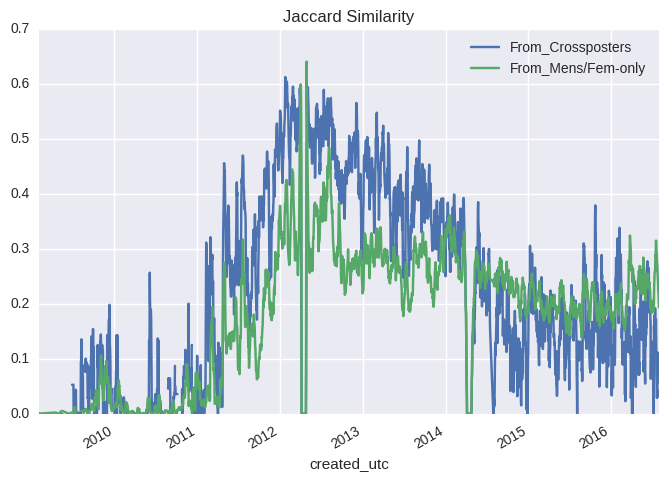

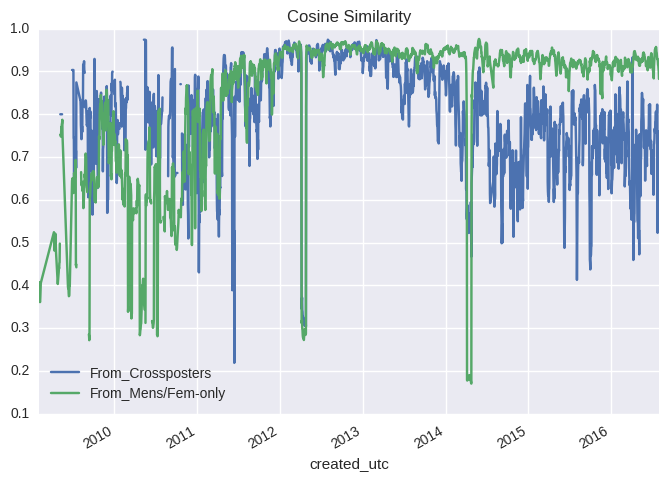

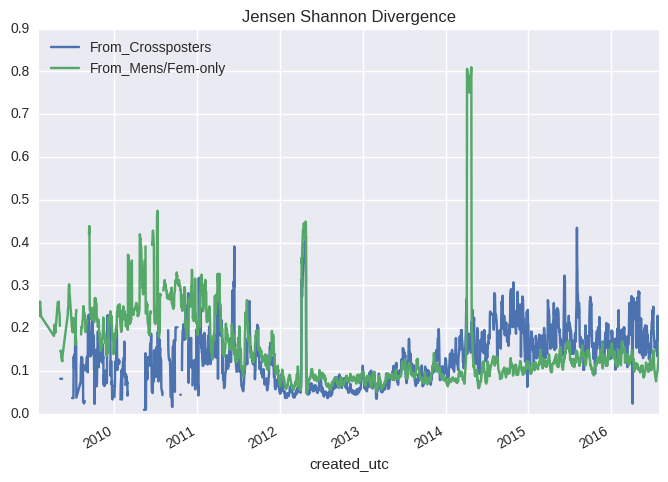

In [20]:
from utils import *

for func, name in zip((jaccard, cosine_sim, jsd),
                      ("Jaccard Similarity", "Cosine Similarity", "Jensen Shannon Divergence")):

    series_cp = counter_cp.apply(func, axis=1)    
    series_mf_only = counter_mf_only.apply(func, axis=1)

    df = pd.concat([series_cp, series_mf_only], axis=1,
                   keys=["From_Crossposters", "From_Mens/Fem-only"])
    df.plot()
    plt.title(name)
    plt.show()

As we saw in the above figures, cross-posters' posts in **MensRights** and **Feminism** subreddits appeared much similar during mid 2012 and mid 2013 than anywhere else, which could be the evidence that they were discussing very narrow range of topics during that period in both subreddits.  

Lastly, let's visualize the most frequent words from posts between mid 2012 and mid 2013 using the wordcloud module (https://github.com/amueller/word_cloud)

In [21]:
srs = ("MensRights", "Feminism")

day_start = datetime.datetime(year=2012, month=6, day=1)
day_end = datetime.datetime(year=2013, month=5, day=31)

for sr in ("MensRights", "Feminism"):
    if sr == "MensRights":
        men_df = DataFrame()
    else:
        fem_df = DataFrame()
        
    fn_wildcard = sr + "_*_*.pickle"
    filenames = glob.glob(fn_wildcard)
    for fn in filenames:
        df = pickle.load(open(fn))
        df = df[(df["created_utc"] >= day_start) &
                (df["created_utc"] <= day_end)]
        if sr == "MensRights":
            men_df = pd.concat([men_df, df], axis=0)
        else:
            fem_df = pd.concat([fem_df, df], axis=0)

men_df = men_df.sort_values(by="created_utc")
men_df = men_df.reset_index(drop=True)

fem_df = fem_df.sort_values(by="created_utc")
fem_df = fem_df.reset_index(drop=True)

men_counter = Counter()
for c in men_df["counter"]:
    men_counter.update(c)
    
fem_counter = Counter()
for c in fem_df["counter"]:
    fem_counter.update(c)

In [22]:
men_counter.most_common(10)

[(u'woman', 247863),
 (u'men', 199878),
 (u'get', 132782),
 (u'say', 130330),
 (u'people', 118996),
 (u'think', 111563),
 (u'make', 108444),
 (u'go', 86242),
 (u'feminist', 79900),
 (u'want', 72996)]

In [23]:
fem_counter.most_common(10)

[(u'woman', 44399),
 (u'men', 27524),
 (u'people', 24196),
 (u'think', 23202),
 (u'say', 23034),
 (u'make', 18776),
 (u'get', 17091),
 (u'rape', 13282),
 (u'feminist', 12519),
 (u'go', 12481)]

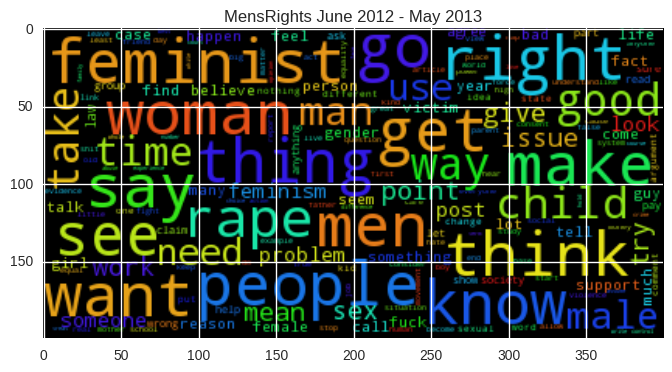

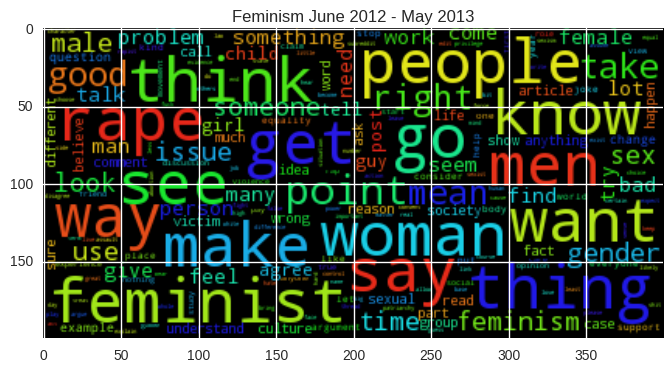

In [25]:
from wordcloud import WordCloud

wc_men = WordCloud(max_font_size=40).generate_from_frequencies((k, men_counter[k]) for k in men_counter.keys())
wc_fem = WordCloud(max_font_size=40).generate_from_frequencies((k, fem_counter[k]) for k in fem_counter.keys())

plt.imshow(wc_men)
plt.title("MensRights June 2012 - May 2013")
plt.show()
plt.imshow(wc_fem)
plt.title("Feminism June 2012 - May 2013")
plt.show()